<a href="https://colab.research.google.com/github/JanNogga/Vision_Systems_Lab/blob/main/Assignment_8/lfw_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import random as rand
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import time
from tqdm.notebook import tqdm
import shutil
import random
from skimage import io

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
if not os.path.exists('data'):
    os.makedirs('data')
try:
  shutil.rmtree('data/lfw')
except:
  pass

In [4]:
print('Extracting files...')
!unzip /content/gdrive/MyDrive/lfw.zip -d data &> /dev/null
print('Done')

Extracting files...
Done


In [5]:
root = 'data/lfw/'
mode = 'Train'
# Path to file which encodes the split
split_file = root + 'peopleDev' + mode + '.txt'
# Keep only subjects who are featured in at least N images
N = 2
# Read the names of all subjects along with the number of photos that each is featured in
tmp_train = np.genfromtxt(split_file, skip_header=1, dtype=np.str)
# Store this info in separate numpy arrays
labels_train, num_images_train= [], []
for label, num_img in tmp_train:
  labels_train.append(label)
  num_images_train.append(int(num_img))
num_images_train = np.array(num_images_train)
labels_train = np.array(labels_train)
print('Number of people featured in the training data:', len(num_images_train))
train_mask = num_images_train >= N
print(f'Number of people featured in at least {N} images: {train_mask.sum()}')
# Obtain the names of the subjects that are kept
masked_labels_train = labels_train[train_mask]
# Assign each name an integer label
label_inds_train = np.arange(len(masked_labels_train))
# Obtain the number of images that each subject kept is featured in
masked_num_images_train = num_images_train[train_mask]
# For each remaining image in the data obtain the corresponding label
train_item_inds = np.repeat(label_inds_train, masked_num_images_train)
print(f'Total number of images in the training data: {train_item_inds.shape[0]}')
# For each remaining image cache at which index it is in its respective folder
local_item_inds_train = [np.arange(n_imgs)+1 for n_imgs in masked_num_images_train]
local_item_inds_train = np.concatenate(local_item_inds_train)
# Convert this to a list of all filenames of images in the training data
filenames_train = [root+'lfw/'+masked_labels_train[train_item_inds[i]]+'_'+f'{local_item_inds_train[i]:04d}' for i in range(train_item_inds.shape[0])]
# Print a few of the resulting image paths
print(filenames_train[:10])

Number of people featured in the training data: 4038
Number of people featured in at least 2 images: 1184
Total number of images in the training data: 6671
['data/lfw/lfw/Aaron_Peirsol_0001', 'data/lfw/lfw/Aaron_Peirsol_0002', 'data/lfw/lfw/Aaron_Peirsol_0003', 'data/lfw/lfw/Aaron_Peirsol_0004', 'data/lfw/lfw/Aaron_Sorkin_0001', 'data/lfw/lfw/Aaron_Sorkin_0002', 'data/lfw/lfw/Abdel_Nasser_Assidi_0001', 'data/lfw/lfw/Abdel_Nasser_Assidi_0002', 'data/lfw/lfw/Abdoulaye_Wade_0001', 'data/lfw/lfw/Abdoulaye_Wade_0002']


In [ ]:
root = 'data/lfw/'
mode = 'Train'

# Keep only subjects who are featured in at least N images
N = 2
# Read the names of all subjects along with the number of photos that each is featured in
tmp_train = np.genfromtxt(split_file, skip_header=1, dtype=np.str)
# Store this info in separate numpy arrays
labels_train, num_images_train= [], []
for label, num_img in tmp_train:
  labels_train.append(label)
  num_images_train.append(int(num_img))
num_images_train = np.array(num_images_train)
labels_train = np.array(labels_train)
print('Number of people featured in the training data:', len(num_images_train))
train_mask = num_images_train >= N
print(f'Number of people featured in at least {N} images: {train_mask.sum()}')
# Obtain the names of the subjects that are kept
masked_labels_train = labels_train[train_mask]
# Assign each name an integer label
label_inds_train = np.arange(len(masked_labels_train))
# Obtain the number of images that each subject kept is featured in
masked_num_images_train = num_images_train[train_mask]
# For each remaining image in the data obtain the corresponding label
train_item_inds = np.repeat(label_inds_train, masked_num_images_train)
print(f'Total number of images in the training data: {train_item_inds.shape[0]}')
# For each remaining image cache at which index it is in its respective folder
local_item_inds_train = [np.arange(n_imgs)+1 for n_imgs in masked_num_images_train]
local_item_inds_train = np.concatenate(local_item_inds_train)
# Convert this to a list of all filenames of images in the training data
filenames_train = [root+'lfw/'+masked_labels_train[train_item_inds[i]]+'_'+f'{local_item_inds_train[i]:04d}' for i in range(train_item_inds.shape[0])]
# Print a few of the resulting image paths
print(filenames_train[:10])

In [6]:
mode = 'Test'
# Path to file which encodes the split
split_file = root + 'peopleDev' + mode + '.txt'
# Keep only subjects who are featured in at least N images
N = 2
# Read the names of all subjects along with the number of photos that each is featured in
tmp_test = np.genfromtxt(split_file, skip_header=1, dtype=np.str)
# Store this info in separate numpy arrays
labels_test, num_images_test= [], []
for label, num_img in tmp_test:
  labels_test.append(label)
  num_images_test.append(int(num_img))
num_images_test = np.array(num_images_test)
labels_test = np.array(labels_test)
print('Number of people featured in the testing data:', len(num_images_test))
test_mask = num_images_test >= N
print(f'Number of people featured in at least {N} images: {test_mask.sum()}')
# Obtain the names of the subjects that are kept
masked_labels_test = labels_test[test_mask]
# Assign each name an integer label
label_inds_test = np.arange(len(masked_labels_test))
# Obtain the number of images that each subject kept is featured in
masked_num_images_test = num_images_test[test_mask]
# For each remaining image in the data obtain the corresponding label
test_item_inds = np.repeat(label_inds_test, masked_num_images_test)
print(f'Total number of images in the testing data: {test_item_inds.shape[0]}')
# For each remaining image cache at which index it is in its respective folder
local_item_inds_test = [np.arange(n_imgs)+1 for n_imgs in masked_num_images_test]
local_item_inds_test = np.concatenate(local_item_inds_test)
# Convert this to a list of all filenames of images in the testing data
filenames_test = [root+'lfw/'+masked_labels_test[test_item_inds[i]]+'_'+f'{local_item_inds_test[i]:04d}' for i in range(test_item_inds.shape[0])]
# Print a few of the resulting image paths
print(filenames_test[:15])

Number of people featured in the testing data: 1711
Number of people featured in at least 2 images: 496
Total number of images in the testing data: 2493
['data/lfw/lfw/Abdullah_Gul_0001', 'data/lfw/lfw/Abdullah_Gul_0002', 'data/lfw/lfw/Abdullah_Gul_0003', 'data/lfw/lfw/Abdullah_Gul_0004', 'data/lfw/lfw/Abdullah_Gul_0005', 'data/lfw/lfw/Abdullah_Gul_0006', 'data/lfw/lfw/Abdullah_Gul_0007', 'data/lfw/lfw/Abdullah_Gul_0008', 'data/lfw/lfw/Abdullah_Gul_0009', 'data/lfw/lfw/Abdullah_Gul_0010', 'data/lfw/lfw/Abdullah_Gul_0011', 'data/lfw/lfw/Abdullah_Gul_0012', 'data/lfw/lfw/Abdullah_Gul_0013', 'data/lfw/lfw/Abdullah_Gul_0014', 'data/lfw/lfw/Abdullah_Gul_0015']


In [37]:
from torch.utils.data import Dataset

class TripletDataset(Dataset):
    """
    Dataset class which draws from the LFW file structure based on text files describing training and validation splits.
    The available modes are 'Train' and 'Test', referencing the suggested training and testing splits for LFW.
    For a triplet dataset, anchor images and positive examples should be different images, so only images featuring people featured in at least N >= 2 images are considered.
    By default, all images are transformed using transform, and anchor, positive and negative are additionally transformed beforehand using transform_anchor, etc.
    """
    def __init__(self, root, N=2, mode='Train', transform=None, transform_anchor=None, transform_positive=None, transform_negative=None):
        """ Dataset initializer"""
        self.root = root
        self.N = N
        assert self.N >= 2, 'A person must be featured in at least 2 images, please adjust N'
        # File which describes which images are in training/testing sets
        self.split_file = root + 'peopleDev' + mode + '.txt'
        # Read the names of all subjects along with the number of photos that each is featured in
        tmp = np.genfromtxt(self.split_file, skip_header=1, dtype=np.str)
        # Store this info in separate numpy arrays
        labels, num_images= [], []
        for label, num_img in tmp:
          labels.append(label)
          num_images.append(int(num_img))
        num_images = np.array(num_images)
        labels = np.array(labels)
        mask = num_images >= self.N
        # Obtain the names of the subjects that are kept
        masked_labels = labels[mask]
        self.classes = masked_labels
        # Assign each name an integer label
        label_inds = np.arange(len(masked_labels))
        # Obtain the number of images that each subject kept is featured in
        masked_num_images = num_images[mask]
        # For each remaining image in the data obtain the corresponding label
        self.item_labels = np.repeat(label_inds, masked_num_images)
        # For each remaining image cache at which index it is in its respective folder
        local_item_inds = [np.arange(n_imgs)+1 for n_imgs in masked_num_images]
        local_item_inds = np.concatenate(local_item_inds)
        # Convert this to a list of all filenames of images in the testing data
        self.filenames = [self.root+'lfw/'+masked_labels[self.item_labels[i]]+'/'+masked_labels[self.item_labels[i]]+'_'+f'{local_item_inds[i]:04d}.jpg' for i in range(self.item_labels.shape[0])]
        self.arange= np.arange(len(self.filenames))
        self.transform = transform
        self.transform_anchor = transform_anchor
        self.transform_positive = transform_positive
        self.transform_negative = transform_negative

        return
    
    def __len__(self):
        """ Returning number of anchors """
        return len(self.filenames)

    def __getitem__(self, i):
        """ 
        Sampling a triplet for the dataset. Index i corresponds to anchor 
        """
        # Obtain the anchor
        anchor_img_path, anchor_lbl = self.filenames[i], self.item_labels[i]
        # Set up indices and labels not containing the anchor element
        ids = np.delete(self.arange, i)
        labels = np.delete(self.item_labels, i)
        # Partition this into positive and negative examples
        pos_ids = ids[labels == anchor_lbl]
        neg_ids = ids[labels != anchor_lbl]
        # Sample random positive and negative example
        pos_id, neg_id = random.choice(pos_ids).item(), random.choice(neg_ids).item()
        pos_img_path, pos_lbl = self.filenames[pos_id], self.item_labels[pos_id]
        neg_img_path, neg_lbl = self.filenames[neg_id], self.item_labels[neg_id]
        
        anchor_img, pos_img, neg_img = io.imread(anchor_img_path), io.imread(pos_img_path), io.imread(neg_img_path)
        if self.transform_anchor:
            anchor_img = self.transform_anchor(anchor_img)
        if self.transform_positive:
            pos_img = self.transform_positive(pos_img)
        if self.transform_negative:
            neg_img = self.transform_negative(neg_img)
        if self.transform:
            anchor_img, pos_img, neg_img = self.transform(anchor_img), self.transform(pos_img), self.transform(neg_img)

              
        return (anchor_img, pos_img, neg_img), (anchor_lbl, pos_lbl, neg_lbl)

In [98]:
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = MEAN, std = STD)
])

pos_transform = transforms.Compose([transforms.RandomResizedCrop(size=(250,250), scale=(0.8, 1.0)),
                                    transforms.RandomHorizontalFlip(p=0.5), 
                                    transforms.ColorJitter(brightness=0.1, contrast=.4, saturation=0.2, hue=0.05)
])

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(MEAN, STD)],
   std= [1/s for s in STD]
)

train_dataset = TripletDataset(root='data/lfw/', mode='Train', transform=data_transforms, transform_positive=pos_transform)
train_names = train_dataset.classes

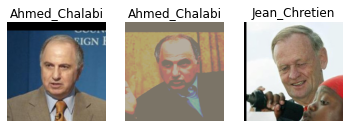

In [99]:
(anchor_img, pos_img, neg_img), (anchor_l, pos_l, neg_l) = train_dataset[42]
_, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(inv_normalize(anchor_img).permute(1,2,0))
ax1.axis('off')
ax1.set_title(train_names[anchor_l])
ax2.imshow(inv_normalize(pos_img).permute(1,2,0))
ax2.axis('off')
ax2.set_title(train_names[pos_l])
ax3.imshow(inv_normalize(neg_img).permute(1,2,0))
ax3.axis('off')
ax3.set_title(train_names[neg_l])
plt.show()